<a href="https://colab.research.google.com/github/a-kalaam/my-deep-learning-path/blob/main/vgg16%20animal%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!kaggle datasets download -d "borhanitrash/animal-image-classification-dataset"

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
animal-image-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip /content/animal-image-classification-dataset.zip

Archive:  /content/animal-image-classification-dataset.zip
replace Animals/cats/0_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install split-folders


In [2]:
!unzip /content/animal-image-classification-dataset.zip


Archive:  /content/animal-image-classification-dataset.zip
  inflating: Animals/cats/0_0001.jpg  
  inflating: Animals/cats/0_0002.jpg  
  inflating: Animals/cats/0_0003.jpg  
  inflating: Animals/cats/0_0004.jpg  
  inflating: Animals/cats/0_0005.jpg  
  inflating: Animals/cats/0_0006.jpg  
  inflating: Animals/cats/0_0007.jpg  
  inflating: Animals/cats/0_0008.jpg  
  inflating: Animals/cats/0_0009.jpg  
  inflating: Animals/cats/0_0010.jpg  
  inflating: Animals/cats/0_0011.jpg  
  inflating: Animals/cats/0_0012.jpg  
  inflating: Animals/cats/0_0013.jpg  
  inflating: Animals/cats/0_0014.jpg  
  inflating: Animals/cats/0_0015.jpg  
  inflating: Animals/cats/0_0016.jpg  
  inflating: Animals/cats/0_0017.jpg  
  inflating: Animals/cats/0_0018.jpg  
  inflating: Animals/cats/0_0019.jpg  
  inflating: Animals/cats/0_0020.jpg  
  inflating: Animals/cats/0_0021.jpg  
  inflating: Animals/cats/0_0022.jpg  
  inflating: Animals/cats/0_0023.jpg  
  inflating: Animals/cats/0_0024.jpg  
  inf

In [61]:
# prompt: force remove directories

!rm -rf /content/Animals_Split/

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths
DATASET_PATH = "/content/Animals"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [8]:
# Load train dataset
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 2400 images belonging to 3 classes.


In [9]:
# Load validation dataset
val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 600 images belonging to 3 classes.


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load VGG16 without the top layer (pretrained on ImageNet)
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze base model layers (so they don't get trained)
for layer in base_model.layers:
    layer.trainable = False

# Create new model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer (num_classes = number of animal categories)
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Unfreeze last 4 layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile again with a lower learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary again
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,692,355 (105.64 MB)

 Trainable params: 20,057,091 (76.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [16]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,692,355 (105.64 MB)

 Trainable params: 20,057,091 (76.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [18]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 570ms/step - accuracy: 0.8466 - loss: 0.3506 - val_accuracy: 0.9183 - val_loss: 0.2256
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.8941 - loss: 0.2628 - val_accuracy: 0.9050 - val_loss: 0.3002
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 579ms/step - accuracy: 0.9026 - loss: 0.2474 - val_accuracy: 0.9283 - val_loss: 0.2170
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.9145 - loss: 0.1838 - val_accuracy: 0.9167 - val_loss: 0.2121
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.9329 - loss: 0.1735 - val_accuracy: 0.9250 - val_loss: 0.2047
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.9413 - loss: 0.1554 - val_accuracy: 0.9350 - val_loss: 0.1900
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 540ms/step - accuracy: 0.9521 - loss: 0.1429 - val_accuracy: 0.9383 - val_loss: 0.1765
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.9486 - loss: 0.1360 - val_accu

In [19]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.9487 - loss: 0.1563
Validation Accuracy: 0.94


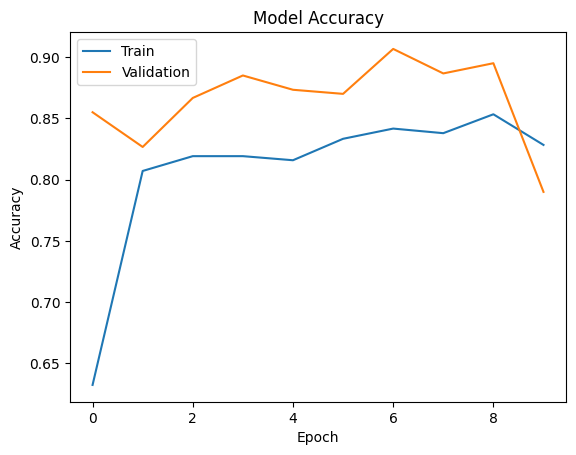

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



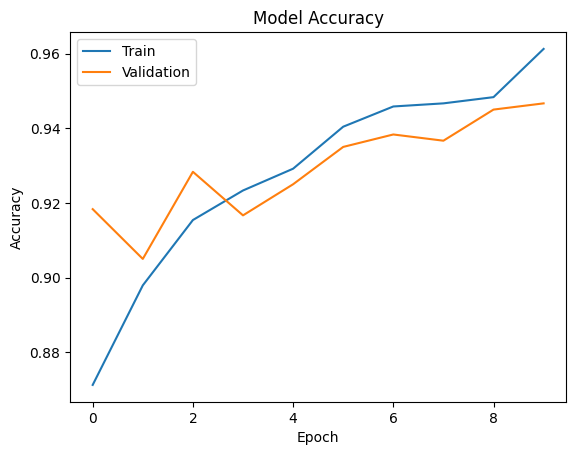

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')